In [261]:
# ASTR 400B Homework 5
# Mass distribution and rotation curves of galaxies MW, M31, and M33
# Savannah Smith

In [262]:
# import modules

import numpy as np
import astropy.units as u
from astropy.constants import G
import matplotlib.pyplot as plt

from ReadFile import Read
from CenterOfMass import CenterOfMass

In [263]:
class MassProfile:
# class to determine the mass distribution of a given galaxy and simulation snapshot

    def __init__(self, galaxy, snap):
        '''
        initializing the class to calculate the mass distribution of a given galaxy at a 
        simulation snapshot

        PARAMETERS
        ----------
            galaxy: 'str'
                the galaxy name (MW, M31, or M33)
            snap: 'int'
                snapshot number (e.g. 0, 1, ...)
        '''

        # forming the file name from its components (galaxy name and snapshot number)
        
        # adding a string of the file number to the value “000”
        ilbl = '000' + str(snap)
        # removing all but the last 3 digits
        ilbl = ilbl[-3:]
        self.filename = '%s_'%(galaxy) + ilbl + '.txt'

        # storing the name of the galaxy as a global property
        self.gname = galaxy 
        
        # reading data in the given file using Read from ReadFile.py
        self.time, self.total, self.data = Read(self.filename)

        # storing the mass and positions of the particles
        self.m = self.data['m']*(10**10)  # adjusting the power to match data
        self.x = self.data['x']*u.kpc
        self.y = self.data['y']*u.kpc
        self.z = self.data['z']*u.kpc

        # changing the units of G so that velocity will be in km/s
        self.G = G.to(u.kpc*u.km**2/u.s**2/u.Msun) 
        

    def MassEnclosed(self, ptype, r):
        '''
        calculates the mass enclosed within a given radius for a specified galaxy 
        and a specified component of that galaxy

        PARAMETERS:
        ----------
            r: 'array of floats'
                magnitudes of the radii 
            ptype: 'int; 1 (halo), 2 (disk), or 3 (bulge)'
                particle type to use for mass calculations

        RETURNS:
        -------
            mass_encl: 'array of astropy quantities'
                enclosed masses for an array of radii in units of solar mass
        '''
        
        # creating a CenterOfMass object using ptype = 2 for disk particle
        # using disk particles to determine the COM object but the mass profile will still 
        # be valid for any particle type (bulge, disk, or halo)
        COM_object = CenterOfMass(self.filename, 2)
        # storing the x, y, and z coordinates of the COM in kpc
        COM_position = COM_object.COM_P(0.1)  # using a delta of 0.1
        
        # creating an array to store indexes of particles of the desired ptype
        index = np.where(self.data['type'] == ptype)

        # collecting values for the variables with the requested particle type
        m_new = self.m[index]
        x_new = self.x[index]
        y_new = self.y[index]
        z_new = self.z[index]

        # finding where the particle is relative to the COM
        x_dist = x_new - COM_position[0]
        y_dist = y_new - COM_position[1]
        z_dist = z_new - COM_position[2]
        r_dist = np.sqrt( (x_dist ** 2) + (y_dist ** 2) + (z_dist ** 2) )

        # ensuring that the radii array has units of kpc
        r_kpc = r*u.kpc

        # initializing the variable so values can be added in the for loop
        mass_encl = np.zeros(len(r))
        # looping over the radius array
        for i in range(len(r)):
            # only adding the mass if the particle's distance from the COM is less than 
            # the specified radius from the array of radii
            index_dist = np.where(r_dist < r_kpc[i])
            mass_encl[i] = np.sum(m_new[index_dist])
        
        return mass_encl*u.Msun  # assigning units of Msun using astropy
        

    def MassEnclosedTotal(self, r):
        '''
        computes the total mass enclosed inside of each radius value within the 1D array

        PARAMETERS:
        ----------
            r: '1D array of floats'
                magnitudes of the radii

        RETURNS:
        -------
            mass_encl_total: '1D array of astropy quantities'
                total enclosed mass at each radius in units of solar mass
        '''
        
        # calling MassEnclosed for each galaxy and particle type (bulge+disk+halo)

        # for the halo and disk (present for all galaxies)
        m_halo = self.MassEnclosed(1, r)  # halo
        m_disk = self.MassEnclosed(2, r)  # disk

        # for the bulge (only present for MW and M31, not M33)
        if self.gname == 'M33':
            m_bulge = 0
        else:
            m_bulge = self.MassEnclosed(3, r)

        mass_encl_total = m_halo + m_halo + m_bulge
        return mass_encl_total


    def HernquistMass(self, radius, h_a, Mhalo):
        '''
        computes the mass enclosed within a given radius using the theoretical profile

        PARAMETERS:
        ----------
            radius: 'astropy quantity'
                the galactocentric distance in kpc
            h_a: 'astropy quantity'
                scale radius of the Hernquist profile in kpc
            Mhalo: 'float'
                total halo mass in units of 1e12 solar mass

        RETURNS:
        -------
            hernquist_m:  'astropy quantity'
                total mass within the input radius in Msun
        '''

        # ensuring variables have astropy units of kpc
        radius_kpc = radius*u.kpc
        h_a_kpc = h_a*u.kpc

        # eqtn for Hernquist mass: M(r) = (Mhalo * (r^2)) / ((a + r)^2)
        # splitting the equation into parts
        a = Mhalo * u.Msun 
        b = radius_kpc ** 2 / (h_a_kpc + radius_kpc) ** 2
        
        hernquist_m = a * b  # calculating hernquist mass
        
        return hernquist_m
    
        
    def CircularVelocity(self, ptype, r):
        '''
        computes the circular velocity of the mass enclosed at each radius, 
        assuming spherical symmetry

        PARAMETERS:
        ----------
            ptype: 'int'
                particle type (1, 2, or 3)
            r: '1D array of floats'
                magnitudes of the radii

        RETURNS:
        -------
            circ_v: '1D array of astropy quantities'
                circular speed of the individual galaxy components at each radius in km/s
        '''

        # ensuring the array of radii has units of kpc
        r_kpc = r*u.kpc

        # storing the enclosed mass
        encl_mass = self.MassEnclosed(ptype, r)

        # eqtn for circular velocity: v = sqrt( (G * m) / r )
        # calculating the term inside the square root
        a = (self.G * encl_mass) / r_kpc
        # taking the square root of the above term and rounding the final value
        circ_v = np.round(np.sqrt(a), 2)

        return circ_v

    
    def CircularVelocityTotal(self, r):
        '''
        computes the total circular velocity of the mass enclosed at each radius, 
        assuming spherical symmetry

        PARAMETERS:
        ----------
            r: '1D array of floats'
                magnitudes of the radii

        RETURNS:
        -------
            circ_v_total: '1D array of astropy quantities'
                circular velocity of all galaxy components at each radius in km/s
        '''

        # ensuring the array of radii has units of kpc
        r_kpc = r*u.kpc

        # storing the total enclosed mass
        encl_mass_total = self.MassEnclosedTotal(r)

        # eqtn for circular velocity: v = sqrt( (G * m) / r )
        # calculating the term inside the square root
        b = (self.G * encl_mass_total) / r_kpc
        # taking the square root of the above term and rounding the final value
        circ_v_total = np.round(np.sqrt(b), 2)

        return circ_v_total


    def HernquistVCirc(self, radius, h_a, Mhalo):
        '''
        computes the circular speed using the Hernquist mass profile

        PARAMETERS:
        ----------
            radius: 'astropy quantity'
                the galactocentric distance in kpc
            h_a: 'astropy quantity'
                scale radius of the Hernquist profile in kpc
            Mhalo: 'float'
                total halo mass in units of 1e12 solar mass

        RETURNS:
        -------
            hernquist_circ_v: 'astropy quantity'
                circular speed of the galaxy in km/s
        '''

        # ensuring radius and scale radius has units of kpc
        radius_kpc = radius*u.kpc
        h_a_kpc = h_a*u.kpc
        
        # eqtn for Hernquist mass: M(r) = (Mhalo * (r^2)) / ((a + r)^2)
        # splitting the equation into parts
        c = Mhalo * u.Msun 
        d = radius_kpc ** 2 / (h_a_kpc + radius_kpc) ** 2

        hernquist_m = c * d  # calculating hernquist mass

        # eqtn for circular velocity: v = sqrt( (G * m) / r )
        # calculating the term inside the square root
        f = (self.G * hernquist_m) / radius_kpc
        # taking the square root of the above term and rounding the final value
        hernquist_circ_v = np.round(np.sqrt(f), 2)

        return hernquist_circ_v


In [264]:
# creating mass profiles for each galaxy at snapshot zero

MW = MassProfile('MW', 0)
M31 = MassProfile('M31', 0)
M33 = MassProfile('M33', 0)

# defining a radius array for mass and velocity calculations
# starting at 0.1 and ending at 50 with 500 steps
r = np.linspace(0.1, 50, 1000)

In [265]:
# plotting the mass profile for each galaxy:

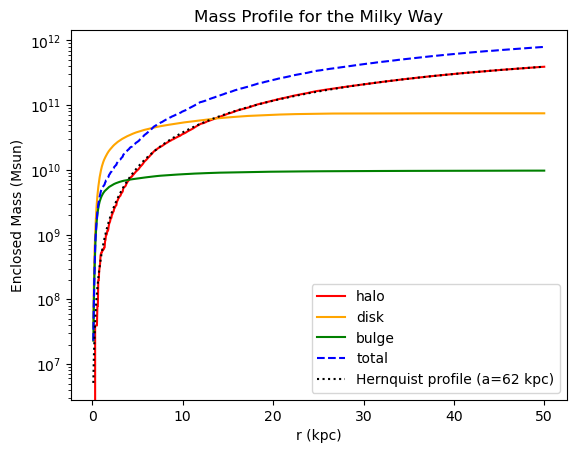

<Figure size 640x480 with 0 Axes>

In [266]:
# for the MW:

# importing the enclosed masses for every particle type at every radius
MW_haloM = MW.MassEnclosed(1, r)
MW_diskM = MW.MassEnclosed(2, r)
MW_bulgeM = MW.MassEnclosed(3, r)
MW_totalM = MW.MassEnclosedTotal(r)

# need to determine values to the best fitting Hernquist profile

# value collected from GalaxyMass.py from homework 3
MW_MhaloTotal = 1.975e12  # units of Msun
# adjusted to find the best fit
MW_hern_a = 62

# calling hernquist mass at the scale radius and halo mass
MW_hern_m = MW.HernquistMass(r, MW_hern_a, MW_MhaloTotal)

# plotting the mass profile
plt.title('Mass Profile for the Milky Way')
plt.xlabel('r (kpc)')
plt.ylabel('Enclosed Mass (Msun)')
plt.semilogy(r, MW_haloM, color='red', label='halo')
plt.semilogy(r, MW_diskM, color='orange', label='disk')
plt.semilogy(r, MW_bulgeM, color='green', label='bulge')
plt.semilogy(r, MW_totalM, color='blue', linestyle='--', label='total')
plt.semilogy(r, MW_hern_m, color='black', linestyle=':', label=f'Hernquist profile (a={MW_hern_a} kpc)')
plt.legend()
plt.show()

plt.savefig('MWMassProfile.png')


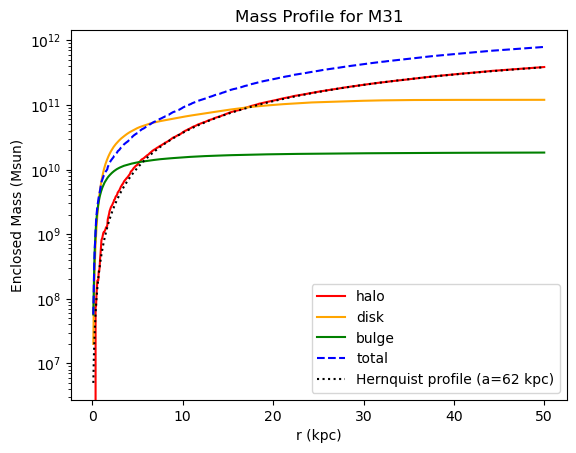

<Figure size 640x480 with 0 Axes>

In [267]:
# for M31:

# importing the enclosed masses for every particle type at every radius
M31_haloM = M31.MassEnclosed(1, r)
M31_diskM = M31.MassEnclosed(2, r)
M31_bulgeM = M31.MassEnclosed(3, r)
M31_totalM = M31.MassEnclosedTotal(r)

# need to determine values to the best fitting Hernquist profile

# value collected from GalaxyMass.py from homework 3
M31_MhaloTotal = 1.921e12  # units in Msun
# adjusted to find the best fit
M31_hern_a = 62

# calling hernquist mass at the scale radius and halo mass
M31_hern_m = M31.HernquistMass(r, M31_hern_a, M31_MhaloTotal)

# plotting the mass profile
plt.title('Mass Profile for M31')
plt.xlabel('r (kpc)')
plt.ylabel('Enclosed Mass (Msun)')
plt.semilogy(r, M31_haloM, color='red', label='halo')
plt.semilogy(r, M31_diskM, color='orange', label='disk')
plt.semilogy(r, M31_bulgeM, color='green', label='bulge')
plt.semilogy(r, M31_totalM, color='blue', linestyle='--', label='total')
plt.semilogy(r, M31_hern_m, color='black', linestyle=':', label=f'Hernquist profile (a={M31_hern_a} kpc)')
plt.legend()
plt.show()

plt.savefig('M31MassProfile.png')


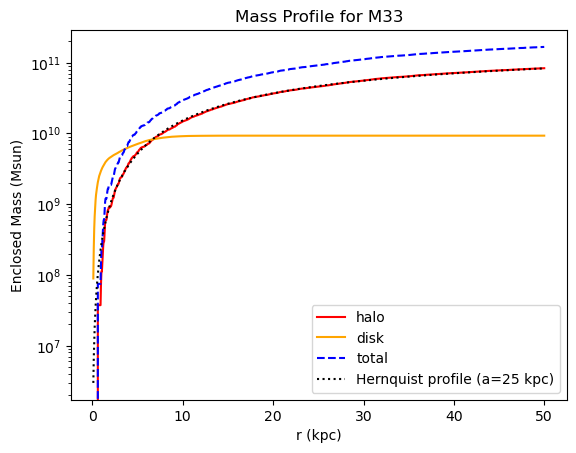

<Figure size 640x480 with 0 Axes>

In [268]:
# for M33:

# importing the enclosed masses for every particle type at every radius
M33_haloM = M33.MassEnclosed(1, r)
M33_diskM = M33.MassEnclosed(2, r)
M33_bulgeM = 0.0 * M33.MassEnclosed(3, r)
M33_totalM = M33.MassEnclosedTotal(r)

# need to determine values to the best fitting Hernquist profile

# value collected from GalaxyMass.py from homework 3
M33_MhaloTotal = 0.187e12  # units of Msun
# adjusted to find the best fit
M33_hern_a = 25

# calling hernquist mass at the scale radius and halo mass
M33_hern_m = M33.HernquistMass(r, M33_hern_a, M33_MhaloTotal)

# plotting the mass profile
plt.title('Mass Profile for M33')
plt.xlabel('r (kpc)')
plt.ylabel('Enclosed Mass (Msun)')
plt.semilogy(r, M33_haloM, color='red', label='halo')
plt.semilogy(r, M33_diskM, color='orange', label='disk')
plt.semilogy(r, M33_totalM, color='blue', linestyle='--', label='total')
plt.semilogy(r, M33_hern_m, color='black', linestyle=':', label=f'Hernquist profile (a={M33_hern_a} kpc)')
plt.legend()
plt.show()

plt.savefig('M33MassProfile.png')


In [269]:
# plotting the rotations curve for each galaxy:

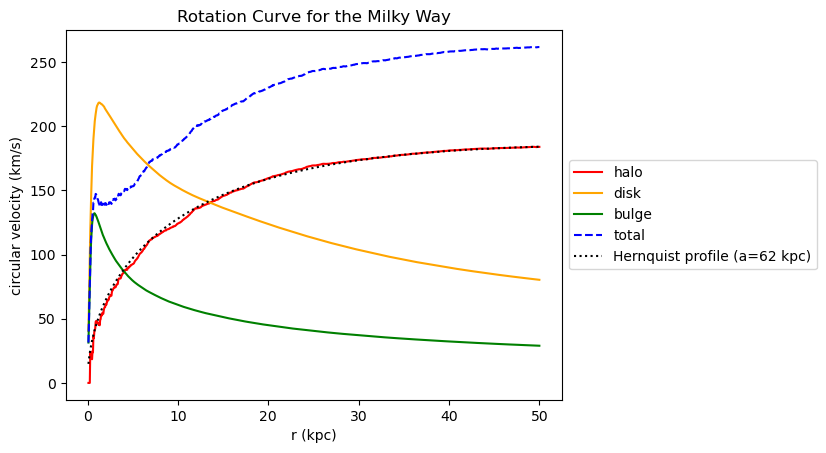

<Figure size 640x480 with 0 Axes>

In [270]:
# for the MW:

# importing the circular velocities for every particle type at every radius
MW_haloV = MW.CircularVelocity(1, r)
MW_diskV = MW.CircularVelocity(2, r)
MW_bulgeV = MW.CircularVelocity(3, r)
MW_totalV = MW.CircularVelocityTotal(r)

# calling the hernquist circular velocity at the scale radius a and halo mass
MW_hern_CV = MW.HernquistVCirc(r, MW_hern_a, MW_MhaloTotal)

# plotting the rotation curve
plt.title('Rotation Curve for the Milky Way')
plt.xlabel('r (kpc)')
plt.ylabel('circular velocity (km/s)')
plt.plot(r, MW_haloV, color='red', label='halo')
plt.plot(r, MW_diskV, color='orange', label='disk')
plt.plot(r, MW_bulgeV, color='green', label='bulge')
plt.plot(r, MW_totalV, color='blue', linestyle='--', label='total')
plt.plot(r, MW_hern_CV, color='black', linestyle=':', label=f'Hernquist profile (a={MW_hern_a} kpc)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.savefig('MWRotationCurve.png')


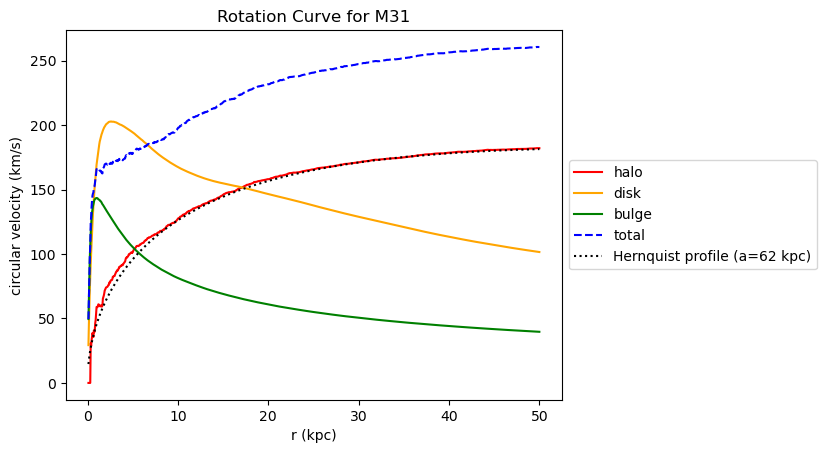

<Figure size 640x480 with 0 Axes>

In [271]:
# for M31:

# importing the circular velocities for every particle type at every radius
M31_haloV = M31.CircularVelocity(1, r)
M31_diskV = M31.CircularVelocity(2, r)
M31_bulgeV = M31.CircularVelocity(3, r)
M31_totalV = M31.CircularVelocityTotal(r)

# calling the hernquist circular velocity at the scale radius a and halo mass
M31_hern_CV = M31.HernquistVCirc(r, M31_hern_a, M31_MhaloTotal)

# plotting the rotation curve
plt.title('Rotation Curve for M31')
plt.xlabel('r (kpc)')
plt.ylabel('circular velocity (km/s)')
plt.plot(r, M31_haloV, color='red', label='halo')
plt.plot(r, M31_diskV, color='orange', label='disk')
plt.plot(r, M31_bulgeV, color='green', label='bulge')
plt.plot(r, M31_totalV, color='blue', linestyle='--', label='total')
plt.plot(r, M31_hern_CV, color='black', linestyle=':', label=f'Hernquist profile (a={M31_hern_a} kpc)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.savefig('M31RotationCurve.png')


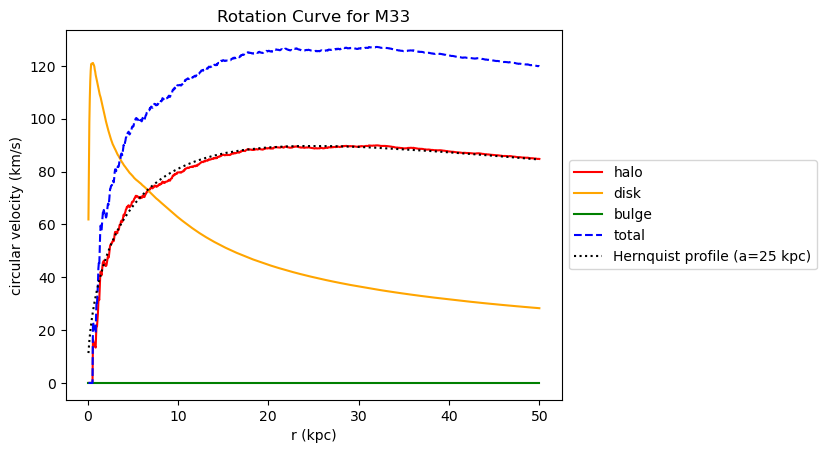

<Figure size 640x480 with 0 Axes>

In [272]:
# for M33:

# importing the circular velocities for every particle type at every radius
M33_haloV = M33.CircularVelocity(1, r)
M33_diskV = M33.CircularVelocity(2, r)
M33_bulgeV = M33.CircularVelocity(3, r)
M33_totalV = M33.CircularVelocityTotal(r)

# calling the hernquist circular velocity at the scale radius a and halo mass
M33_hern_CV = M33.HernquistVCirc(r, M33_hern_a, M33_MhaloTotal)

# plotting the rotation curve
plt.title('Rotation Curve for M33')
plt.xlabel('r (kpc)')
plt.ylabel('circular velocity (km/s)')
plt.plot(r, M33_haloV, color='red', label='halo')
plt.plot(r, M33_diskV, color='orange', label='disk')
plt.plot(r, M33_bulgeV, color='green', label='bulge')
plt.plot(r, M33_totalV, color='blue', linestyle='--', label='total')
plt.plot(r, M33_hern_CV, color='black', linestyle=':', label=f'Hernquist profile (a={M33_hern_a} kpc)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.savefig('M33RotationCurve.png')
